设Q是所有可能的状态的集合，V是所有可能的观测的集合。

其中，N是可能的状态数，M是可能的观测数。

I是长度为T的状态序列，O是对应的观测序列。

A是状态转移概率矩阵：

其中

是在时刻t处于状态qi的条件下在时刻t+1转移到状态qj的概率。

B是观测概率矩阵：

其中

是在时刻t处于状态qj的条件下生成观测vk的概率

π是初始状态概率向量：

其中

是时刻t=1处于状态qi的概率

隐马尔可夫模型由初始状态概率向量π、状态转移概率矩阵A和观测概率矩阵B决定。π和A决定状态序列，B决定观测序列。因此，隐马尔可夫模型λ可以用三元符号表示，即

                            λ=(A,B,π)
                       
A,B,π称为隐马尔可夫模型的三要素。

In [1]:
import numpy as np

In [116]:
class hiddenMarkovModel:
    def __init__(self):
        self.alphas=[]
        self.betas=[]
        self.I=[]
        self.psises=[]
        self.A=None
        self.B=None
        self.PI=None
        self.e=1e-5
        

    def forward(self,Q,V,A,B,PI,T,O):
        #Q状态集合，V观测集合，A状态转移概率矩阵，B观测概率矩阵，PI初始状态概率向量，T轮数，O观测序列
        N=len(Q)
        alpha=np.zeros((N,1))
        for t in range(T):
            index = V.index(O[t])
            if t==0:
                alpha=np.multiply(B[:,index],PI)
            else:
                alpha=np.multiply(alpha.T.dot(A).T,B[:,index])

            self.alphas.append(alpha)

            print("iter {}, alpha:\n{}".format(t+1,alpha))

        P=np.sum(alpha)

        print("P(O|λ)=",P)
        print("forward algorithm complete!")


    def backward(self,Q,V,A,B,PI,T,O):
        # Q状态集合，V观测集合，A状态转移概率矩阵，B观测概率矩阵，PI初始状态概率向量，T轮数，O观测序列
        N = len(Q)
        beta = np.ones((N, 1))
        self.betas.append(beta)
        for t in reversed(range(T-1)):
            index = V.index(O[t+1])
            tmp=np.multiply(B[:,index],beta)
            beta=A.dot(tmp)
            self.betas.insert(0,beta)
            print("iter {}, beta:\n{}".format(t + 1, beta))

        P=beta.T.dot(np.multiply(B[:,V.index(O[0])],PI))[0,0]

        print("P(O|λ)=", P)
        print("backward algorithm complete!")


    def viterbi(self,Q,V,A,B,PI,T,O):
        N=len(Q)
        delta=np.zeros((N,1))
        for t in range(T):
            index = V.index(O[t])
            if t==0:  #初始化
                delta=np.multiply(B[:,index],PI)
                psis = np.zeros((N, 1))
            else:
                tmp=np.multiply(delta,A)
                delta=np.multiply(np.max(tmp,axis=0).T,B[:,index])
                psis=np.argmax(tmp,axis=0).T+1
            self.psises.append(psis)
            print("iter {}, delta:\n{}\npsis:\n{}".format(t + 1,delta ,psis))

        P=np.max(delta)
        i=np.argmax(delta)+1
        self.I.append(i)
        for t in reversed(range(T-1)):
            i=self.psises[t+1][i-1,0]
            self.I.insert(0,i)
        print("I=({})".format(self.I))
        print("viterbi algorithm complete!")
        
        
    def approximate(self,T):  #需要先运行前向后向算法计算出α和β
        I=[]
        for t in range(T):
            gamma=np.multiply(self.alphas[t],self.betas[t])/self.alphas[t].T.dot(self.betas[t])
            i=np.argmax(gamma)+1
            I.append(i)
        print("I=({})".format(I))
        print("approximate algorithm complete!")
        
        
    def BaumWelch(self,Q,V,A,B,PI,T,O):
        self.A=A
        self.B=B
        self.PI=PI
        while True:
            self.forward(Q,V,A,B,PI,T,O)
            self.backward(Q,V,A,B,PI,T,O)
            gamma=sum([np.multiply(self.alphas[t],self.betas[t])/self.alphas[t].T.dot(self.betas[t]) for t in range(T-1)])
            epsilons=self.calcEpsilon(A,B,O,T)
            A=np.divide(epsilons,gamma)
            m,n=B.shape
            for i in range(m):
                for j in range(n):
                    B_denominator=sum([self.alphas[t][j]*self.betas[t][j]/self.alphas[t].T.dot(self.betas[t]) for t in range(T)])
                    B_numerator=sum([self.alphas[t][j]*self.betas[t][j]/self.alphas[t].T.dot(self.betas[t]) for t in range(T) if O[t]==V[j]])
                    B[i,j]=B_numerator/B_denominator
            
            PI=np.multiply(self.alphas[0],self.betas[0])/self.alphas[0].T.dot(self.betas[0])
            if np.linalg.norm(PI-self.PI)<self.e or np.linalg.norm(A-self.A)<self.e or np.linalg.norm(B-self.B)<self.e :
                break
            self.A=A
            self.B=B
            self.PI=PI
        
        print("π:",PI)
        print("Baum-Welch algorithm complete!")
            



    def calcEpsilon(self,A,B,O,T):
        epsilons=0
        for t in range(T-1):
            index=V.index(O[t+1])
            tmpA=np.multiply(self.alphas[t],A)
            tmpB=np.multiply(B[:,index],self.betas[t+1])
            epsilon=np.multiply(tmpA,tmpB.T)/np.sum(tmpA.dot(tmpB))
            epsilons+=epsilon
        return epsilons



In [117]:
hmm=hiddenMarkovModel()
Q=[1,2,3]
V=[u'红',u'白']
A=np.mat([[0.5,0.2,0.3],[0.3,0.5,0.2],[0.2,0.3,0.5]])
B=np.mat([[0.5,0.5],[0.4,0.6],[0.7,0.3]])
PI=np.mat([[0.2],[0.4],[0.4]])
T=3
O=[u'红',u'白',u'红']
hmm.forward(Q,V,A,B,PI,T,O)

iter 1, alpha:
[[0.1 ]
 [0.16]
 [0.28]]
iter 2, alpha:
[[0.077 ]
 [0.1104]
 [0.0606]]
iter 3, alpha:
[[0.04187 ]
 [0.035512]
 [0.052836]]
P(O|λ)= 0.130218
forward algorithm complete!


In [118]:
hmm.backward(Q,V,A,B,PI,T,O)

iter 2, beta:
[[0.54]
 [0.49]
 [0.57]]
iter 1, beta:
[[0.2451]
 [0.2622]
 [0.2277]]
P(O|λ)= 0.130218
backward algorithm complete!


In [119]:
hmm.viterbi(Q,V,A,B,PI,T,O)
hmm.approximate(T)

iter 1, delta:
[[0.1 ]
 [0.16]
 [0.28]]
psis:
[[0.]
 [0.]
 [0.]]
iter 2, delta:
[[0.028 ]
 [0.0504]
 [0.042 ]]
psis:
[[3]
 [3]
 [3]]
iter 3, delta:
[[0.00756]
 [0.01008]
 [0.0147 ]]
psis:
[[2]
 [2]
 [3]]
I=([3, 3, 3])
viterbi algorithm complete!
I=([3, 2, 3])
approximate algorithm complete!


In [120]:
hmm.BaumWelch(Q,V,A,B,PI,T,O)

iter 1, alpha:
[[0.1 ]
 [0.16]
 [0.28]]
iter 2, alpha:
[[0.077 ]
 [0.1104]
 [0.0606]]
iter 3, alpha:
[[0.04187 ]
 [0.035512]
 [0.052836]]
P(O|λ)= 0.130218
forward algorithm complete!
iter 2, beta:
[[0.54]
 [0.49]
 [0.57]]
iter 1, beta:
[[0.2451]
 [0.2622]
 [0.2277]]
P(O|λ)= 0.130218
backward algorithm complete!
π: [[0.18822283]
 [0.32216744]
 [0.48960973]]
Baum-Welch algorithm complete!


# 习题10.1

In [90]:
Q=[1,2,3]
V=[u'红',u'白']
A=np.mat([[0.5,0.2,0.3],[0.3,0.5,0.2],[0.2,0.3,0.5]])
B=np.mat([[0.5,0.5],[0.4,0.6],[0.7,0.3]])
PI=np.mat([[0.2],[0.4],[0.4]])
T=4
O=[u'红',u'白',u'红',u'白']
h=hiddenMarkovModel()
h.backward(Q,V,A,B,PI,T,O)

iter 3, beta:
[[0.46]
 [0.51]
 [0.43]]
iter 2, beta:
[[0.2461]
 [0.2312]
 [0.2577]]
iter 1, beta:
[[0.112462]
 [0.121737]
 [0.104881]]
P(O|λ)= 0.06009079999999999
backward algorithm complete!


# 习题10.2

In [91]:
Q=[1,2,3]
V=[u'红',u'白']
A=np.mat([[0.5,0.1,0.4],[0.3,0.5,0.2],[0.2,0.2,0.6]])
B=np.mat([[0.5,0.5],[0.4,0.6],[0.7,0.3]])
PI=np.mat([[0.2],[0.3],[0.5]])
T=8
O=[u'红',u'白',u'红',u'红',u'白',u'红',u'白',u'白']
h.forward(Q,V,A,B,PI,T,O)
print("\n\n")
h.backward(Q,V,A,B,PI,T,O)


iter 1, alpha:
[[0.1 ]
 [0.12]
 [0.35]]
iter 2, alpha:
[[0.078 ]
 [0.084 ]
 [0.0822]]
iter 3, alpha:
[[0.04032 ]
 [0.026496]
 [0.068124]]
iter 4, alpha:
[[0.0208668 ]
 [0.01236192]
 [0.04361112]]
iter 5, alpha:
[[0.0114321 ]
 [0.01019392]
 [0.01109573]]
iter 6, alpha:
[[0.00549669]
 [0.00338373]
 [0.00928834]]
iter 7, alpha:
[[0.00281056]
 [0.00245952]
 [0.00253453]]
iter 8, alpha:
[[0.00132502]
 [0.00121063]
 [0.00094105]]
P(O|λ)= 0.0034767094492823996
forward algorithm complete!



iter 7, beta:
[[0.43]
 [0.51]
 [0.4 ]]
iter 6, beta:
[[0.1861]
 [0.2415]
 [0.1762]]
iter 5, beta:
[[0.105521]
 [0.100883]
 [0.111934]]
iter 4, beta:
[[0.04586531]
 [0.05280909]
 [0.04280618]]
iter 3, beta:
[[0.02556442]
 [0.02343448]
 [0.02678985]]
iter 2, beta:
[[0.01482964]
 [0.01227214]
 [0.01568294]]
iter 1, beta:
[[0.00632569]
 [0.00684706]
 [0.00577855]]
P(O|λ)= 0.0034767094492824
backward algorithm complete!


给定模型λ和观测O，在时刻t处于状态qi的概率为

可以得到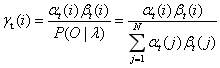

因此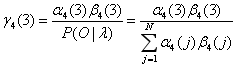

In [84]:
P=h.alphas[3][2]*h.betas[3][2]/h.alphas[3].T.dot(h.betas[3])
print("P(i4=q3|O,λ)=",P[0,0])

P(i4=q3|O,λ)= 0.5369518160647323


# 习题10.3

In [85]:
Q=[1,2,3]
V=[u'红',u'白']
A=np.mat([[0.5,0.2,0.3],[0.3,0.5,0.2],[0.2,0.3,0.5]])
B=np.mat([[0.5,0.5],[0.4,0.6],[0.7,0.3]])
PI=np.mat([[0.2],[0.4],[0.4]])
T=4
O=[u'红',u'白',u'红',u'白']
h.viterbi(Q,V,A,B,PI,T,O)

iter 1, delta:
[[0.1 ]
 [0.16]
 [0.28]]
psis:
[[0.]
 [0.]
 [0.]]
iter 2, delta:
[[0.028 ]
 [0.0504]
 [0.042 ]]
psis:
[[3]
 [3]
 [3]]
iter 3, delta:
[[0.00756]
 [0.01008]
 [0.0147 ]]
psis:
[[2]
 [2]
 [3]]
iter 4, delta:
[[0.00189 ]
 [0.003024]
 [0.002205]]
psis:
[[1]
 [2]
 [3]]
I=([3, 2, 2, 2])
viterbi algorithm complete!
